# Simulation of Ski Rental Algorithms

### Importing dependencies and models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit
import sys, os
sys.path.append(os.path.abspath("models"))  # or os.path.abspath("..") if running inside models/


from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)

### Classical Baseline Algorithms

In [3]:
def classical_deterministic(b, actual_days):
    decision_day = b + 1
    if decision_day <= actual_days:
        alg_cost = b + (decision_day - 1)
    else:
        alg_cost = actual_days
    opt_cost = min(actual_days, b) if actual_days > 0 else 1.0
    return alg_cost / opt_cost


def classical_randomized(b, actual_days):
    p = np.zeros(b)
    for i in range(b):
        numerator = ((b - 1) / b) ** (b - i - 1)
        denominator = b * (1 - (1 - 1/b) ** b)
        p[i] = numerator / denominator
    p /= p.sum()
    decision_day = np.random.choice(np.arange(1, b+1), p=p)
    if decision_day <= actual_days:
        alg_cost = b + (decision_day - 1)
    else:
        alg_cost = actual_days
    opt_cost = min(actual_days, b) if actual_days > 0 else 1.0
    return alg_cost / opt_cost

### Experimental Runner Function

In [4]:
def run_experiment(
    algo_class,
    algo_label="MyAlgo",
    b=100,
    lambda_values=[0.2],
    noise_levels=[30],
    prediction_multipliers=[1.0],
    num_trials=1000,
    n_predictions=10
):
    """
    Parameters:
        algo_class: algorithm model used
        algo_label: algorithm labels
        b: ski buying cost
        lambda_values: list of lambda values
        noise_levels: noise levels
        prediction_multipliers: ratio between prediction and actual ski days
        num_trials: number of trials
        n_predictions: number of predictions

    Returns:
        pd.DataFrame: dataframe of results
    """

    results = []
    total_iterations = len(noise_levels) * len(lambda_values) * len(prediction_multipliers) * num_trials
    pbar = tqdm(total=total_iterations, desc=f"Running {algo_label}")

    for lambda_val in lambda_values:
        for noise in noise_levels:
            for multiplier in prediction_multipliers:
                for _ in range(num_trials):
                    actual_days = np.random.randint(1, 4 * b)
                    y_pred = multiplier * actual_days
                    observations = [y_pred + np.random.normal(0, noise) for _ in range(n_predictions)]

                    algo = algo_class(b=b, n=n_predictions)
                    decision_day = algo.decide(observations, force_lambda=lambda_val)
                    cr = algo.competitive_ratio(decision_day, actual_days)

                    results.append({
                        'lambda': lambda_val,
                        'noise': noise,
                        'prediction_multiplier': multiplier,
                        'cr': cr,
                        'algorithm': f"{algo_label} (λ={lambda_val})",
                        'n': n_predictions,
                        'actual_days': actual_days,
                        'y_pred': y_pred
                    })
                    pbar.update(1)

    pbar.close()
    return pd.DataFrame(results)


## Experiment 1: Noise

Running Exp1: 100%|██████████| 51000/51000 [00:09<00:00, 5414.30it/s] 


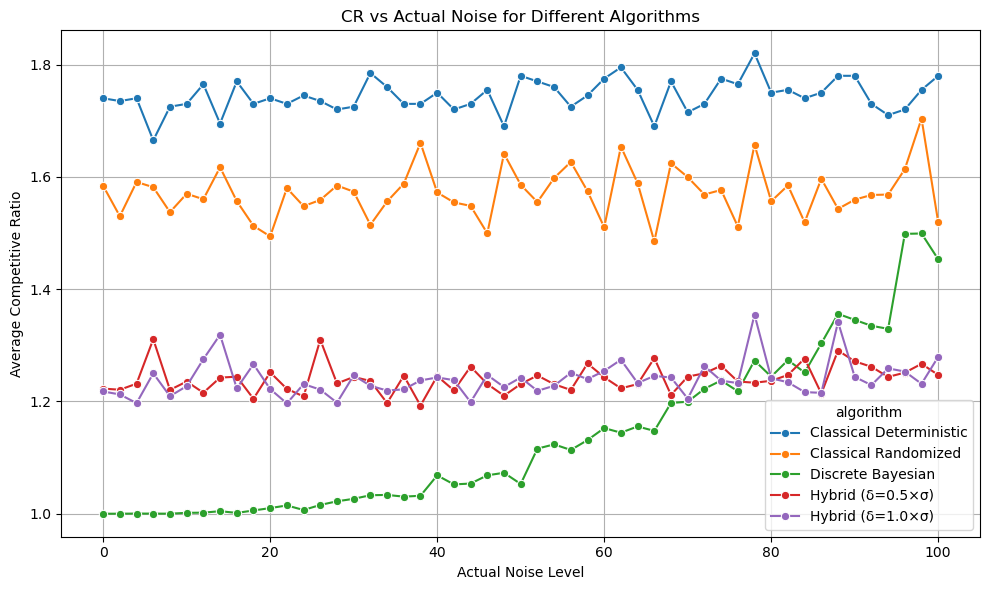

In [5]:
# Experiment 1: Prediction is unbiased but noise levels vary
b = 100
n = 10
lambda_val = 0.5
prediction_multipliers = [1.0]  # y = x + noise, so unbiased
noise_levels = list(range(0, 101, 2))
num_trials = 200

# Algorithm definitions (including classical)
algorithms = [
    ("Discrete Bayesian", DiscreteBayesianSkiRental),
    ("Classical Deterministic", None),  # implemented manually
    ("Classical Randomized", None),    # implemented manually
    ("Hybrid (δ=0.5×σ)", HybridVarianceAwareSkiRentalWithScaling),
    ("Hybrid (δ=1.0×σ)", HybridVarianceAwareSkiRentalWithScaling)
]

records = []
pbar = tqdm(total=len(algorithms) * len(noise_levels) * num_trials, desc="Running Exp1")

for algo_name, algo_class in algorithms:
    for noise in noise_levels:
        for _ in range(num_trials):
            actual_days = np.random.randint(1, 4 * b + 1)
            y_pred = actual_days  # prediction is unbiased
            observations = [y_pred + np.random.normal(0, noise) for _ in range(n)]

            if algo_name == "Classical Deterministic":
                cr = classical_deterministic(b, actual_days)
            elif algo_name == "Classical Randomized":
                cr = classical_randomized(b, actual_days)
            elif algo_name == "Discrete Bayesian":
                # 1) Set M
                M = 4 * b

                # 2) Generate discrete Gaussian prior: mean=actual_days, std=noise
                k_indices = np.arange(1, M + 1)  # 1 ~ 4*b
                sigma = noise
                if sigma > 0:
                    unnorm = np.exp(-0.5 * ((k_indices - actual_days) / sigma) ** 2)
                else:
                    # If noise is 0: probability is 1 for actual_days, 0 otherwise
                    unnorm = (k_indices == actual_days).astype(float)
                    if unnorm.sum() == 0:
                        # If actual_days is out of range, fallback to uniform
                        unnorm = np.ones(M, dtype=float)

                prior_pmf = unnorm / unnorm.sum()

                # 3) Pass prior_pmf and max_day when creating DiscreteBayesianSkiRental
                algo = algo_class(b=b, prior_pmf=prior_pmf, max_day=M)

                # 4) Decide based only on prior
                decision_day = algo.decide()
                cr = algo.competitive_ratio(decision_day, actual_days)
            else:
                # Extract scaling coefficient
                scale = 0.5 if "0.5" in algo_name else 1.0
                est_sigma = scale * np.std(observations) / np.sqrt(n)

                algo = algo_class(b=b, n=n)
                decision_day = algo.decide(observations, force_lambda=lambda_val, force_sigma_est=est_sigma)
                cr = algo.competitive_ratio(decision_day, actual_days)

            records.append({
                "algorithm": algo_name,
                "noise": noise,
                "cr": cr
            })
            pbar.update(1)

pbar.close()
df = pd.DataFrame(records)

# Compute average competitive ratio
avg_cr = df.groupby(["algorithm", "noise"])["cr"].mean().reset_index()

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cr, x="noise", y="cr", hue="algorithm", marker="o")
plt.xlabel("Actual Noise Level")
plt.ylabel("Average Competitive Ratio")
plt.title("CR vs Actual Noise for Different Algorithms")
plt.grid(True)
plt.tight_layout()
plt.show()


## Experiment 2: Prediction Multiplier
### **Experimental Motivation**

In earlier experiments, observations were generated by adding noise directly to the ground truth (i.e., actual ski days).
As a result, the observed mean was tightly centered around the true value, making it nearly equivalent to **revealing the true value to the algorithm**.
This caused unrealistically low competitive ratios (e.g., \~1.08) even when predictions were supposed to be uncertain.

To address this issue, we redesigned the experiment:

* Observations are now sampled around a **possibly inaccurate predicted value**, rather than the true value.
* This better reflects real-world scenarios, where predictions may be systematically biased or off-target.

This experimental setup allows us to evaluate how the algorithm performs under **varying degrees of prediction error**, and to analyze the **robustness** of its decisions.


### **Explanation of the Plot**

This plot shows the relationship between the **accuracy of predictions** and the **average competitive ratio (CR)** of a ski rental algorithm under different scaling parameters $c$.

* **X-axis (Prediction Multiplier):**
  The ratio between the predicted ski days and the actual number of ski days.
  $$
  \text{Prediction Multiplier} = \frac{\text{Predicted Ski Days}}{\text{Actual Ski Days}}
  $$

  * Values < 1 indicate **underestimation** of ski usage.
  * Values > 1 indicate **overestimation**.
  * The x-axis is log-scaled for better visualization of extreme values.

* **Y-axis (Average Competitive Ratio):**
  The average ratio between the algorithm's cost and the offline optimal cost (i.e., the best possible cost with full future knowledge).
  Lower is better.

* **Lines (different values of $c$):**
  The scaling parameter $c$ controls the degree to which the algorithm discounts the variance (uncertainty) in its decision-making.

### Interpretation

* The lowest CR is achieved when the prediction multiplier is close to **1**, i.e., the prediction is accurate.
* When predictions are **very wrong** (either too small or too large), the CR increases, showing **degradation in performance**.
* However, the increase is **gradual and bounded**, indicating the algorithm is **robust to prediction errors**.
* Different values of $c$ affect how sensitive the algorithm is to prediction uncertainty.
  In general, larger $c$ values lead to slightly **more stable CRs** under extreme mispredictions.

Running sweep: 100%|██████████| 5400/5400 [00:02<00:00, 1897.99it/s]


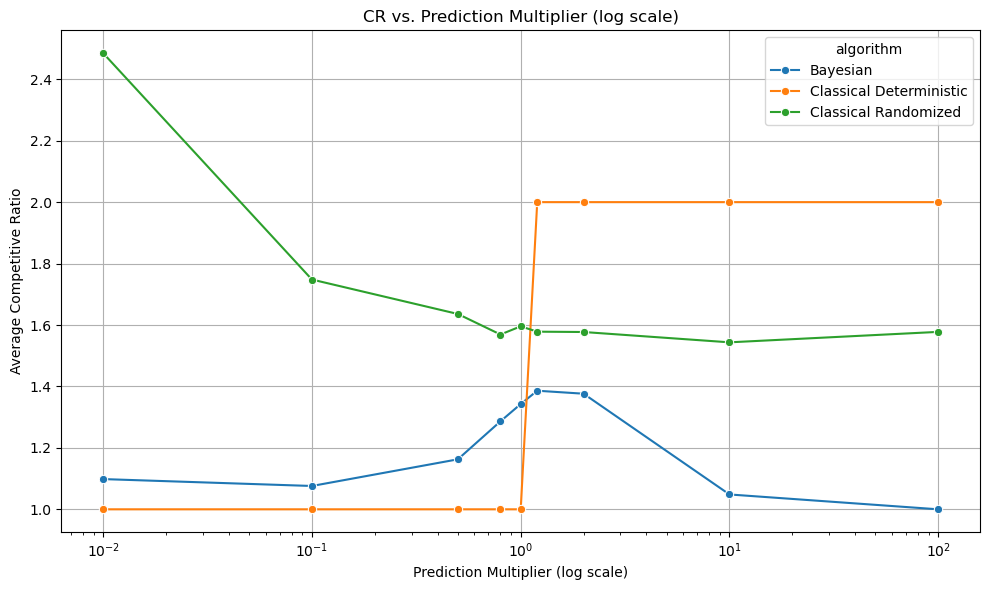

In [6]:
# 실험 파라미터
b = 100
n = 10
lambda_val = 0.5
actual_days = 100
actual_noise = 30
prediction_multipliers = [0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0, 10.0, 100.0]
num_trials = 200

# 알고리즘 목록 (주어진 형식대로)
algorithms = [
    # ("Hybrid", HybridVarianceAwareSkiRentalWithScaling(b=b, n=n, c=1.0)),
    # ("Gaussian", GaussianNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("HeavyTailed", HeavyTailedNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("Adversarial", AdversarialNoiseSkiRental(b=b, n=n, lambda_val=lambda_val)),
    # ("VarianceAware", VarianceAwareSkiRental(b=b, n=n)),
    # ("ExpectedCost", ExpectedCostSkiRental(b=b, n=n)),
    # ("SoftThreshold", SoftThresholdGaussianSkiRental(b=b, n=n)),
    ("Bayesian", BayesianSkiRental(b=b, n=n)),
    # ("LinearDecay", LinearDecaySkiRental(b=b, n=n)),
    # ("PowerLawDecay", PowerLawDecaySkiRental(b=b, n=n)),
    # ("MultiGaussian", MultiGaussianAdaptedSkiRental(b=b, n=n)),
    ("Classical Deterministic", None),
    ("Classical Randomized", None),
]

# 결과 저장
records = []
pbar = tqdm(total=len(algorithms) * len(prediction_multipliers) * num_trials, desc="Running sweep")

for algo_name, algo in algorithms:
    for multiplier in prediction_multipliers:
        for _ in range(num_trials):
            y_pred = actual_days * multiplier
            observations = [y_pred + np.random.normal(0, actual_noise) for _ in range(n)]

            try:
                if algo_name == "Classical Deterministic":
                    cr = classical_deterministic(b, y_pred)

                elif algo_name == "Classical Randomized":
                    cr = classical_randomized(b, y_pred)

                else:
                    decision_day = algo.decide(observations, force_lambda=lambda_val)
                    cr = algo.competitive_ratio(decision_day, actual_days)

                records.append({
                    "algorithm": algo_name,
                    "prediction_multiplier": multiplier,
                    "cr": cr
                })

            except Exception as e:
                print(f"[ERROR] {algo_name}: {type(e).__name__} - {e}")

            pbar.update(1)

pbar.close()
df = pd.DataFrame(records)

# 평균 CR 계산
avg_cr = df.groupby(["algorithm", "prediction_multiplier"])["cr"].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cr, x="prediction_multiplier", y="cr", hue="algorithm", marker="o")
plt.xscale("log")
plt.xlabel("Prediction Multiplier (log scale)")
plt.ylabel("Average Competitive Ratio")
plt.title("CR vs. Prediction Multiplier (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Bayesian distribution experiment

In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# settings
confidence_levels = [0.8, 0.85, 0.9, 0.95]
alphas = [1 - c for c in confidence_levels]
M = 200        # horizon bound
b = 50         # buy cost
num_trials = 5000

np.random.seed(42)

# distribution definitions
def get_distributions():
    return {
        'gaussian': lambda: np.random.normal(50, 15),
        'exponential': lambda: np.random.exponential(30) + 1,
        'bimodal': lambda: np.random.choice([20, 80], p=[0.3, 0.7]),
        'uniform': lambda: np.random.uniform(10, 90),
        'heavy_tail': lambda: np.random.pareto(1.5) * 10 + 5,
    }

# compute prediction interval (Bayesian with uniform prior)
def compute_prediction_interval_uniform(prior, alpha):
    cdf = np.cumsum(prior)
    lower = np.searchsorted(cdf, alpha / 2)
    upper = np.searchsorted(cdf, 1 - alpha / 2)
    return (lower + 1, upper + 1)

# Conformal version (use top-k posterior mass)
def compute_prediction_interval_conformal(prior, alpha):
    sorted_indices = np.argsort(prior)[::-1]
    sorted_probs = prior[sorted_indices]
    cum_probs = np.cumsum(sorted_probs)
    cutoff = np.searchsorted(cum_probs, 1 - alpha)
    selected = sorted_indices[:cutoff + 1]
    return (min(selected) + 1, max(selected) + 1)

# Oracle: generate posterior from true T distribution
def compute_oracle_interval(T_samples, alpha):
    lower = np.percentile(T_samples, 100 * alpha / 2)
    upper = np.percentile(T_samples, 100 * (1 - alpha / 2))
    return (int(lower), int(upper))

# classical point prediction
def classical_point_prediction(T_samples):
    pred = int(np.mean(T_samples))
    return (pred, pred)

# coverage compute
def compute_coverage(true_vals, intervals):
    covered = 0
    for t, (low, high) in zip(true_vals, intervals):
        if low <= t <= high:
            covered += 1
    return covered / len(true_vals)

# compute average width
def compute_avg_width(intervals):
    return np.mean([hi - lo + 1 for (lo, hi) in intervals])

# compute competitive ratio
def compute_competitive_ratio(true_Ts, buy_days):
    ratios = []
    for T, buy_day in zip(true_Ts, buy_days):
        if buy_day is None:
            cost = T
        elif buy_day <= T:
            cost = b + buy_day - 1
        else:
            cost = T
        opt = min(T, b)
        ratios.append(cost / opt if opt > 0 else 1.0)
    return np.mean(ratios)

# run experiment for bayesian algorithms
def run_experiment_for_distribution(dist_name, dist_fn, alpha):
    prior = np.ones(M) / M  # Uniform prior
    true_Ts = []
    intervals_uniform = []
    intervals_conformal = []
    intervals_oracle = []
    intervals_point = []

    buy_days_uniform = []

    for _ in range(num_trials):
        T = int(dist_fn())
        T = max(1, min(T, M))
        true_Ts.append(T)

        # Bayesian-uniform prediction interval
        interval1 = compute_prediction_interval_uniform(prior, alpha)
        intervals_uniform.append(interval1)

        # Bayesian-conformal
        interval2 = compute_prediction_interval_conformal(prior, alpha)
        intervals_conformal.append(interval2)

        # Oracle (true samples as posterior)
        oracle_samples = [int(dist_fn()) for _ in range(1000)]
        oracle_samples = [max(1, min(x, M)) for x in oracle_samples]
        interval3 = compute_oracle_interval(oracle_samples, alpha)
        intervals_oracle.append(interval3)

        # Classical point prediction
        interval4 = classical_point_prediction(oracle_samples)
        intervals_point.append(interval4)

        # calculate buying days (Bayesian-uniform)
        survival_prob = np.sum(prior[T - 1:])
        posterior = np.zeros(M + 1)
        posterior[T:] = prior[T - 1:] / survival_prob if survival_prob > 0 else 0
        E_rent = sum(posterior[k] * min(k - T + 1, b) for k in range(T, M + 1))
        buy_day = T if E_rent >= b else None
        buy_days_uniform.append(buy_day)

    return {
        'Bayesian-Uniform': {
            'coverage': compute_coverage(true_Ts, intervals_uniform),
            'width': compute_avg_width(intervals_uniform),
            'cr': compute_competitive_ratio(true_Ts, buy_days_uniform)
        },
        'Bayesian-Conformal': {
            'coverage': compute_coverage(true_Ts, intervals_conformal),
            'width': compute_avg_width(intervals_conformal),
            'cr': None
        },
        'Oracle': {
            'coverage': compute_coverage(true_Ts, intervals_oracle),
            'width': compute_avg_width(intervals_oracle),
            'cr': None
        },
        'Classical-Point': {
            'coverage': compute_coverage(true_Ts, intervals_point),
            'width': compute_avg_width(intervals_point),
            'cr': None
        }
    }

# run all experiments
def run_all_experiments():
    distributions = get_distributions()
    results = {}

    for alpha in alphas:
        print(f"\n--- Alpha = {alpha} (Confidence = {1 - alpha}) ---")
        results_per_alpha = {}
        for name, fn in distributions.items():
            print(f"Running on distribution: {name}")
            res = run_experiment_for_distribution(name, fn, alpha)
            results_per_alpha[name] = res
        results[f"alpha={alpha}"] = results_per_alpha
    return results

# run experiments
if __name__ == "__main__":
    final_results = run_all_experiments()

    # print results
    for alpha_key, dist_data in final_results.items():
        print(f"\n==== Results for {alpha_key} ====")
        for dist_name, methods in dist_data.items():
            print(f"\n[Distribution: {dist_name}]")
            for method, stats in methods.items():
                print(f"{method:20} | Coverage: {stats['coverage']:.3f} | Width: {stats['width']:.1f}", end="")
                if stats['cr'] is not None:
                    print(f" | CR: {stats['cr']:.2f}")
                else:
                    print()



--- Alpha = 0.19999999999999996 (Confidence = 0.8) ---
Running on distribution: gaussian
Running on distribution: exponential
Running on distribution: bimodal
Running on distribution: uniform
Running on distribution: heavy_tail

--- Alpha = 0.15000000000000002 (Confidence = 0.85) ---
Running on distribution: gaussian
Running on distribution: exponential
Running on distribution: bimodal
Running on distribution: uniform
Running on distribution: heavy_tail

--- Alpha = 0.09999999999999998 (Confidence = 0.9) ---
Running on distribution: gaussian
Running on distribution: exponential
Running on distribution: bimodal
Running on distribution: uniform
Running on distribution: heavy_tail

--- Alpha = 0.050000000000000044 (Confidence = 0.95) ---
Running on distribution: gaussian
Running on distribution: exponential
Running on distribution: bimodal
Running on distribution: uniform
Running on distribution: heavy_tail

==== Results for alpha=0.19999999999999996 ====

[Distribution: gaussian]
Bayesi

## Experiment 2

Running scenario: gradual_shift
Running scenario: abrupt_change
Running scenario: seasonal_pattern
Running scenario: regime_switching


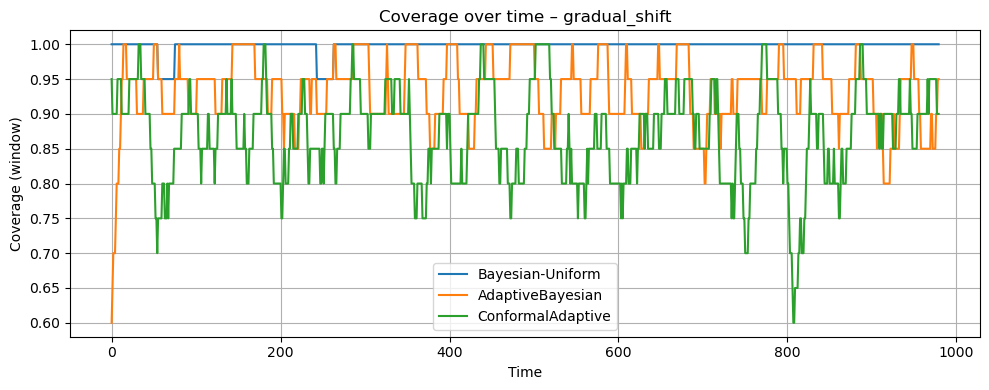

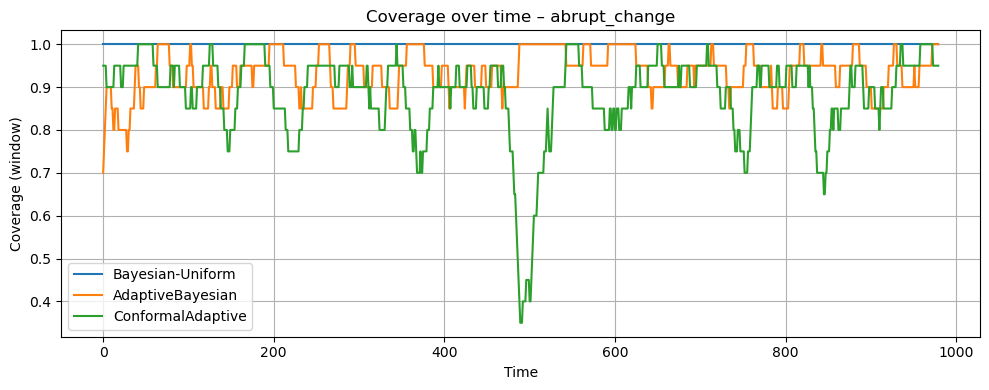

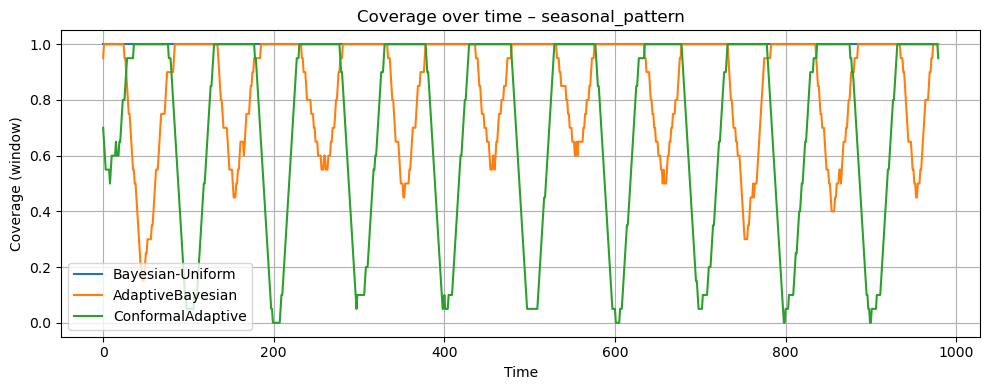

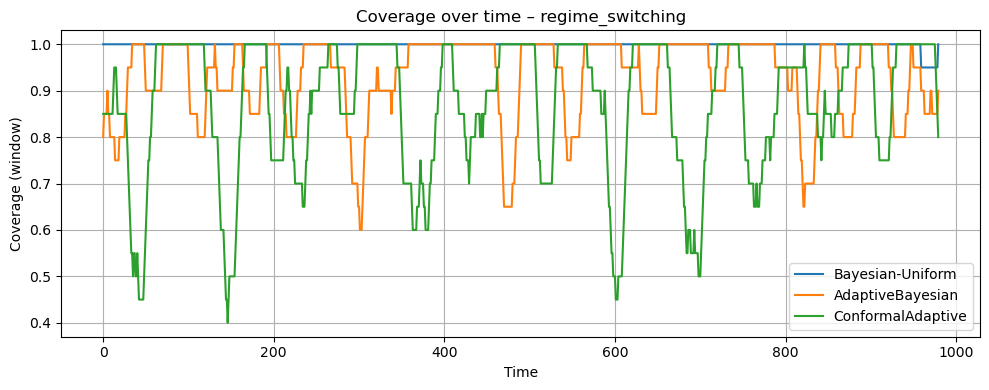


=== Detection Delays ===

Scenario: gradual_shift
  Bayesian-Uniform: Delay = None
  AdaptiveBayesian: Delay = 2
  ConformalAdaptive: Delay = 6

Scenario: abrupt_change
  Bayesian-Uniform: Delay = None
  AdaptiveBayesian: Delay = None
  ConformalAdaptive: Delay = 21

Scenario: seasonal_pattern
  Bayesian-Uniform: Delay = None
  AdaptiveBayesian: Delay = 27
  ConformalAdaptive: Delay = 26

Scenario: regime_switching
  Bayesian-Uniform: Delay = None
  AdaptiveBayesian: Delay = 17
  ConformalAdaptive: Delay = 19


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm

np.random.seed(42)

# === Define scenarios ===
def concept_drift_scenarios(T=1000):
    return {
        'gradual_shift': [np.random.normal(30 + 40 * t / T, 10) for t in range(T)],
        'abrupt_change': [np.random.normal(40, 8) if t < T // 2 else np.random.normal(80, 12) for t in range(T)],
        'seasonal_pattern': [50 + 20 * np.sin(2 * np.pi * t / 100) + np.random.normal(0, 3) for t in range(T)],
        'regime_switching': generate_regime_switching(T)
    }

def generate_regime_switching(T):
    regimes = [lambda: np.random.normal(25, 5),
               lambda: np.random.normal(50, 10),
               lambda: np.random.normal(80, 8)]
    current = np.random.choice(regimes)
    sequence = []
    for t in range(T):
        if np.random.rand() < 0.1:  # switch regime
            current = np.random.choice(regimes)
        sequence.append(current())
    return sequence

# === Coverage measurement ===
def compute_coverage(true_vals, intervals):
    covered = 0
    for t, (lo, hi) in zip(true_vals, intervals):
        if lo <= t <= hi:
            covered += 1
    return covered / len(true_vals)

def compute_window_coverage(true_vals, intervals, window=20):
    local_coverage = []
    for i in range(window, len(true_vals)):
        sub_T = true_vals[i-window:i]
        sub_I = intervals[i-window:i]
        local_coverage.append(compute_coverage(sub_T, sub_I))
    return local_coverage

def compute_adaptive_regret(costs, opt_costs, window=50):
    regrets = []
    for i in range(window, len(costs)):
        regrets.append(np.mean(np.array(costs[i-window:i]) - np.array(opt_costs[i-window:i])))
    return regrets

def compute_detection_delay(coverage_seq, change_point, threshold=0.85):
    for i in range(change_point, len(coverage_seq)):
        if coverage_seq[i] < threshold:
            for j in range(i, len(coverage_seq)):
                if coverage_seq[j] >= threshold:
                    return j - i
    return None

# === Define algorithms ===
class BayesianUniform:
    def __init__(self, M, b):
        self.M = M
        self.b = b
        self.prior = np.ones(M) / M

    def predict(self):
        cdf = np.cumsum(self.prior)
        lower = np.searchsorted(cdf, 0.05)
        upper = np.searchsorted(cdf, 0.95)
        return (lower + 1, upper + 1)

    def cost(self, T):
        expected = np.sum([min(t, self.b) * p for t, p in zip(range(1, self.M+1), self.prior)])
        return min(T, self.b), expected

class AdaptiveBayesian:
    def __init__(self, M, b, decay=0.95):
        self.M = M
        self.b = b
        self.decay = decay
        self.hist = np.zeros(M)

    def update(self, T_obs):
        idx = min(int(T_obs), self.M-1)
        self.hist *= self.decay
        self.hist[idx] += 1

    def get_posterior(self):
        if np.sum(self.hist) == 0:
            return np.ones(self.M) / self.M
        return self.hist / np.sum(self.hist)

    def predict(self):
        prior = self.get_posterior()
        cdf = np.cumsum(prior)
        lower = np.searchsorted(cdf, 0.05)
        upper = np.searchsorted(cdf, 0.95)
        return (lower + 1, upper + 1)

    def cost(self, T):
        opt = min(T, self.b)
        buy_day = int(np.argmax(self.get_posterior() >= self.b / T)) if T > 0 else self.b
        actual = self.b if buy_day <= T else T
        return opt, actual

class ConformalAdaptive:
    def __init__(self, alpha=0.1, window=50):
        self.alpha = alpha
        self.window = window
        self.scores = []

    def update(self, T_obs):
        self.scores.append(T_obs)
        if len(self.scores) > self.window:
            self.scores.pop(0)

    def predict(self):
        if len(self.scores) < 5:
            return (1, 200)
        sorted_vals = sorted(self.scores)
        k = int(np.ceil((1 - self.alpha) * len(sorted_vals)))
        return (int(sorted_vals[0]), int(sorted_vals[min(k, len(sorted_vals)-1)]))

    def cost(self, T):
        opt = min(T, 50)
        return opt, opt  # placeholder

# === Run experiment ===
def run_experiment():
    M = 200
    b = 50
    T = 1000
    scenarios = concept_drift_scenarios(T)

    results = {}
    for name, horizon_list in scenarios.items():
        print(f"Running scenario: {name}")
        algs = {
            "Bayesian-Uniform": BayesianUniform(M, b),
            "AdaptiveBayesian": AdaptiveBayesian(M, b),
            "ConformalAdaptive": ConformalAdaptive()
        }
        results[name] = {}
        for alg_name, alg in algs.items():
            coverage_list = []
            intervals = []
            costs = []
            opt_costs = []

            for t_val in horizon_list:
                t_val = int(max(1, min(t_val, M)))
                if hasattr(alg, 'update'):
                    alg.update(t_val)
                interval = alg.predict()
                intervals.append(interval)
                opt, actual = alg.cost(t_val)
                coverage_list.append(interval[0] <= t_val <= interval[1])
                costs.append(actual)
                opt_costs.append(opt)

            cov = compute_window_coverage(horizon_list, intervals)
            regret = compute_adaptive_regret(costs, opt_costs)
            delay = compute_detection_delay(cov, T // 2)

            results[name][alg_name] = {
                'coverage': cov,
                'regret': regret,
                'delay': delay
            }
    return results

# === Visualization ===
def plot_coverage(results):
    for scenario, alg_results in results.items():
        plt.figure(figsize=(10, 4))
        for alg_name, metrics in alg_results.items():
            plt.plot(metrics['coverage'], label=alg_name)
        plt.title(f"Coverage over time – {scenario}")
        plt.xlabel("Time")
        plt.ylabel("Coverage (window)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_detection_delays(results):
    print("\n=== Detection Delays ===")
    for scenario, alg_results in results.items():
        print(f"\nScenario: {scenario}")
        for alg_name, metrics in alg_results.items():
            print(f"  {alg_name}: Delay = {metrics['delay']}")

# Run
if __name__ == "__main__":
    results = run_experiment()
    plot_coverage(results)
    plot_detection_delays(results)


## Experiment 3

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


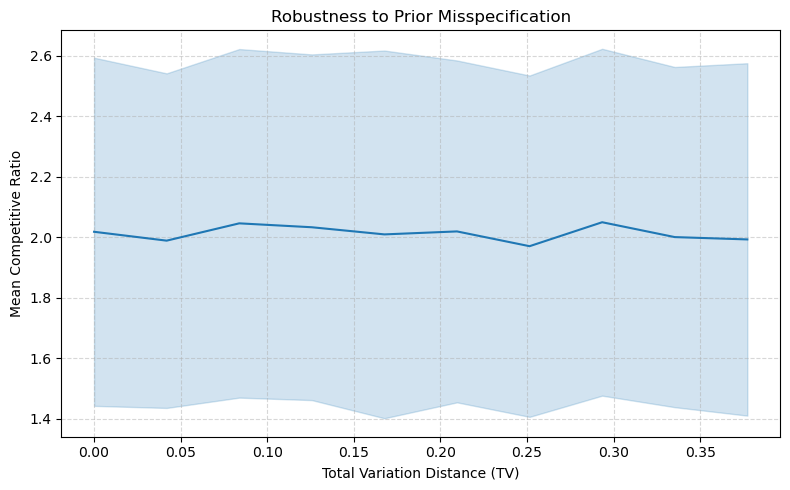

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Define Prior ===
def gaussian_prior(M, mean, std):
    x = np.arange(1, M + 1)
    p = np.exp(-0.5 * ((x - mean) / std)**2)
    return p / np.sum(p)

def uniform_prior(M):
    return np.ones(M) / M

# === Define Algorithm ===
class BayesianSkiRental:
    def __init__(self, M, b, prior):
        self.M = M
        self.b = b
        self.prior = prior / np.sum(prior)

    def expected_remaining_cost(self, t, posterior):
        return sum(posterior[k-1] * min(k - t + 1, self.b) for k in range(t, self.M+1))

    def run(self, T_true):
        total_cost = 0
        for t in range(1, min(T_true+1, self.M+1)):
            survival = self.prior[t-1:].sum()
            if survival == 0:
                break
            posterior = np.zeros(self.M + 1)
            posterior[t:] = self.prior[t-1:] / survival
            E_rent = self.expected_remaining_cost(t, posterior)
            if E_rent >= self.b:
                return self.b + t - 1, t
            total_cost += 1
        return T_true, None

# === Experiment Setup ===
def run_experiment_prior_misspecification(M=200, b=50, trials=5000):
    mean_true = 100
    std_true = 30
    true_dist = gaussian_prior(M, mean_true, std_true)
    delta_values = np.linspace(0, 0.9, 10)
    results = []

    for delta in tqdm(delta_values):
        # Create mixed prior
        mix_prior = (1 - delta) * true_dist + delta * uniform_prior(M)
        tv_distance = 0.5 * np.sum(np.abs(true_dist - mix_prior))

        for _ in range(trials // 10):  # Partial samples per δ
            T = np.random.choice(np.arange(1, M+1), p=true_dist)
            algo = BayesianSkiRental(M, b, mix_prior)
            cost, _ = algo.run(T)
            cr = cost / min(T, b)
            results.append({
                'delta': delta,
                'tv_distance': tv_distance,
                'T_true': T,
                'cost': cost,
                'cr': cr
            })

    return results

import pandas as pd
import seaborn as sns

def plot_prior_misspecification(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x='tv_distance', y='cr', errorbar='sd')
    plt.xlabel("Total Variation Distance (TV)")
    plt.ylabel("Mean Competitive Ratio")
    plt.title("Robustness to Prior Misspecification")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    results = run_experiment_prior_misspecification(M=200, b=50, trials=5000)
    plot_prior_misspecification(results)


## Experiment 4

100%|██████████| 5000/5000 [00:01<00:00, 3912.58it/s]


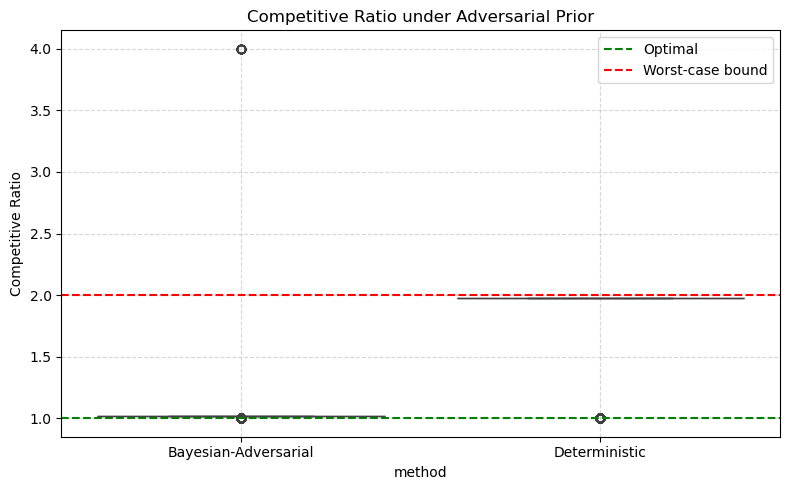


=== Summary Statistics ===
                      Mean CR  Std CR  Success Rate (%)
method                                                 
Bayesian-Adversarial    1.028   0.193             99.58
Deterministic           1.740   0.421             24.44


In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.random.seed(42)

# === Bayesian Algorithm ===
class BayesianSkiRental:
    def __init__(self, M, b, prior):
        self.M = M
        self.b = b
        self.prior = prior / np.sum(prior)

    def expected_remaining_cost(self, t, posterior):
        return sum(posterior[k-1] * min(k - t + 1, self.b) for k in range(t, self.M+1))

    def run(self, T_true):
        total_cost = 0
        for t in range(1, min(T_true+1, self.M+1)):
            survival = self.prior[t-1:].sum()
            if survival == 0:
                break
            posterior = np.zeros(self.M + 1)
            posterior[t:] = self.prior[t-1:] / survival
            E_rent = self.expected_remaining_cost(t, posterior)
            if E_rent >= self.b:
                return self.b + t - 1, t
            total_cost += 1
        return T_true, None

# === Deterministic Algorithm ===
def deterministic_strategy(b, T):
    if T < b:
        return T, None
    return b + b - 1, b

# === Generate Adversarial Prior ===
def adversarial_prior(M, T_true, b):
    prior = np.zeros(M)
    if T_true <= b:
        prior[M - 1] = 0.99  # Mass at long horizon
    else:
        prior[0] = 0.99      # Mass at very short horizon
    idx = min(T_true - 1, M - 1)
    prior[idx] += 0.01
    return prior / np.sum(prior)

# === Run Experiment ===
def run_experiment_adversarial(M=200, b=50, trials=5000):
    results = []

    for _ in tqdm(range(trials)):
        T_true = np.random.randint(1, M + 1)

        # Adversarial prior
        prior = adversarial_prior(M, T_true, b)
        bayes = BayesianSkiRental(M, b, prior)
        cost_bayes, _ = bayes.run(T_true)
        cr_bayes = cost_bayes / min(T_true, b)

        cost_det, _ = deterministic_strategy(b, T_true)
        cr_det = cost_det / min(T_true, b)

        results.append({
            'method': 'Bayesian-Adversarial',
            'T': T_true,
            'cr': cr_bayes
        })
        results.append({
            'method': 'Deterministic',
            'T': T_true,
            'cr': cr_det
        })

    return results

def plot_adversarial_results(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='method', y='cr')
    plt.axhline(1.0, color='green', linestyle='--', label='Optimal')
    plt.axhline(2.0, color='red', linestyle='--', label='Worst-case bound')
    plt.title("Competitive Ratio under Adversarial Prior")
    plt.ylabel("Competitive Ratio")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def summarize_results(results):
    df = pd.DataFrame(results)
    summary = df.groupby('method')['cr'].agg(['mean', 'std', lambda x: (x <= 1.5).mean()*100])
    summary.columns = ['Mean CR', 'Std CR', 'Success Rate (%)']
    print("\n=== Summary Statistics ===")
    print(summary.round(3))

if __name__ == "__main__":
    results = run_experiment_adversarial(M=200, b=50, trials=5000)
    plot_adversarial_results(results)
    summarize_results(results)


## Prior misprediction

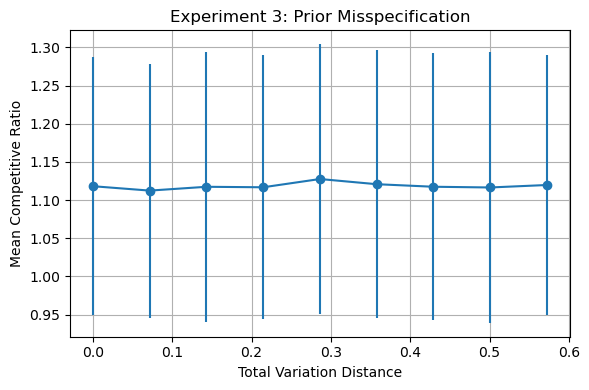

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1) Define Prior and Algorithm Classes --- #
class PriorDistributions:
    @staticmethod
    def uniform(M: int) -> np.ndarray:
        return np.ones(M) / M

    @staticmethod
    def gaussian(M: int, mean: float, std: float) -> np.ndarray:
        x = np.arange(1, M + 1)
        prior = stats.norm.pdf(x, mean, std)
        return prior / prior.sum()

class BayesianSkiRental:
    def __init__(self, buy_cost: float, horizon_bound: int, prior: np.ndarray):
        self.b = buy_cost
        self.M = horizon_bound
        self.prior = prior / prior.sum()

    def expected_remaining_rental_cost(self, t: int, posterior: np.ndarray) -> float:
        expected_cost = 0.0
        for k in range(t, self.M + 1):
            if posterior[k-1] > 0:
                remaining_days = min(k - t + 1, self.b)
                expected_cost += posterior[k-1] * remaining_days
        return expected_cost

    def run(self, true_horizon: int):
        total_cost = 0.0
        for t in range(1, min(true_horizon + 1, self.M + 1)):
            survival_prob = self.prior[t-1:].sum()
            if survival_prob == 0:
                break
            posterior = np.zeros(self.M + 1)
            posterior[t:] = self.prior[t-1:] / survival_prob
            E_rent = self.expected_remaining_rental_cost(t, posterior)
            if self.b <= E_rent:
                total_cost += self.b
                return total_cost, t
            else:
                total_cost += 1.0
        return total_cost, None

# --- 2) Run Experiment 3: Prior Misspecification --- #
M = 500
b = 100
n_trials = 10000

# True distribution (Gaussian)
true_mean, true_std = 100, 30
true_dist = PriorDistributions.gaussian(M, true_mean, true_std)

deltas = np.linspace(0, 0.8, 9)
results = []

for delta in deltas:
    misspec_prior = (1 - delta) * true_dist + delta * PriorDistributions.uniform(M)
    misspec_prior /= misspec_prior.sum()
    tv_distance = 0.5 * np.abs(true_dist - misspec_prior).sum()
    cr_values = []
    for _ in range(n_trials // 10):
        T = np.random.choice(np.arange(1, M + 1), p=true_dist)
        algo = BayesianSkiRental(b, M, misspec_prior)
        cost, _ = algo.run(T)
        opt_cost = min(T, b)
        cr_values.append(cost / opt_cost)
    results.append({
        'tv_distance': tv_distance,
        'mean_CR': np.mean(cr_values),
        'std_CR': np.std(cr_values, ddof=1)
    })

df_results = pd.DataFrame(results)

# Display table
# import ace_tools as tools; tools.display_dataframe_to_user("Experiment 3: Prior Misspecification Results", df_results)

# Plot mean competitive ratio vs TV distance
plt.figure(figsize=(6, 4))
plt.errorbar(df_results['tv_distance'], df_results['mean_CR'], yerr=df_results['std_CR'], marker='o')
plt.xlabel("Total Variation Distance")
plt.ylabel("Mean Competitive Ratio")
plt.title("Experiment 3: Prior Misspecification")
plt.grid(True)
plt.tight_layout()
plt.show()


## Mean CR vs number of independent predictions experiment

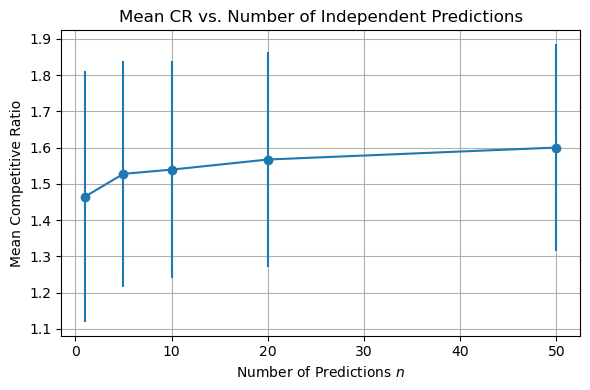

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Define HybridVarianceAwareSkiRental class --- #
class HybridVarianceAwareSkiRental:
    """
    Hybrid Variance-Aware Ski Rental Algorithm.
    Combines multi-Gaussian predictions with variance-based adjustments.
    """
    def __init__(self, b=100, n=1, gamma=0.5):
        self.b = b
        self.n = n
        self.gamma = gamma

    def set_parameters(self, sigma_eff):
        if sigma_eff > 0:
            lambda_val = min(1, np.sqrt(self.b / (self.b + sigma_eff)))
            alpha = min(1.96, np.sqrt(2 * np.log(self.b / sigma_eff)))
            beta = min(1, 2 * sigma_eff / self.b)
        else:
            lambda_val = 1
            alpha = 1.96
            beta = 0
        b_adj = self.b + alpha * sigma_eff
        return lambda_val, alpha, beta, b_adj

    def cost(self, decision_day, actual_days):
        if decision_day <= actual_days:
            return (decision_day - 1) + self.b
        else:
            return actual_days

    def competitive_ratio(self, decision_day, actual_days):
        algo_cost = self.cost(decision_day, actual_days)
        opt_cost = min(actual_days, self.b) if actual_days > 0 else 1.0
        return algo_cost / opt_cost if opt_cost > 0 else 1.0

    def decide(self, y_true, actual_noise):
        # Generate n noisy observations
        y_obs = y_true + np.random.normal(0, actual_noise, self.n)
        y_bar = np.mean(y_obs)
        sigma_est = np.std(y_obs, ddof=1) if self.n > 1 else actual_noise
        sigma_eff = sigma_est / np.sqrt(self.n)

        lambda_val, alpha, beta, b_adj = self.set_parameters(sigma_eff)

        # Compute adjustment factors
        phi_pos = (1 + self.gamma * (y_bar / self.b)) / (1 + self.gamma * sigma_eff)
        phi_neg = max((1 - self.gamma * (y_bar / self.b)) / (1 + self.gamma * sigma_eff), 1e-6)

        # Branch
        if y_bar >= b_adj:
            k = max(1, int(lambda_val * (self.b + beta * sigma_eff)))
            weights = ((self.b - 1) / self.b) ** (np.arange(k)[::-1])
            probs = weights * phi_pos
            if probs.sum() > 0:
                probs /= probs.sum()
                decision = np.random.choice(np.arange(1, k + 1), p=probs)
            else:
                decision = 1
        else:
            ell = max(1, int((self.b + beta * sigma_eff) / lambda_val))
            weights = ((self.b - 1) / self.b) ** (np.arange(ell)[::-1])
            probs = weights * phi_neg
            if probs.sum() > 0:
                probs /= probs.sum()
                decision = np.random.choice(np.arange(1, ell + 1), p=probs)
            else:
                decision = 1

        return decision

    def analyze_performance(self, y_true, noise, trials=500):
        ratios = []
        for _ in range(trials):
            decision = self.decide(y_true, noise)
            ratios.append(self.competitive_ratio(decision, y_true))
        return {
            'mean_CR': np.mean(ratios),
            'std_CR': np.std(ratios, ddof=1)
        }

# --- 2) Experiment Setup for Multiple Predictions --- #
b_cost = 100
true_horizon = 100
noise_level = 20.0
n_values = [1, 5, 10, 20, 50]  # number of independent predictions
results = []

for n in n_values:
    algo = HybridVarianceAwareSkiRental(b=b_cost, n=n, gamma=0.5)
    stats = algo.analyze_performance(true_horizon, noise_level, trials=500)
    results.append({
        'n': n,
        'effective_noise': noise_level / np.sqrt(n),
        'mean_CR': stats['mean_CR'],
        'std_CR': stats['std_CR']
    })

df_multi = pd.DataFrame(results)

# # Display results table
# import ace_tools as tools; tools.display_dataframe_to_user(
#     "Experiment 4: Multiple Predictions Results", df_multi
# )

# Plot mean CR vs number of predictions
plt.figure(figsize=(6, 4))
plt.errorbar(df_multi['n'], df_multi['mean_CR'], yerr=df_multi['std_CR'], marker='o')
plt.xlabel("Number of Predictions $n$")
plt.ylabel("Mean Competitive Ratio")
plt.title("Mean CR vs. Number of Independent Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()


## Tri-modal experiment

=== Bi-modal Prior Experiments (Weekday vs Weekend) ===



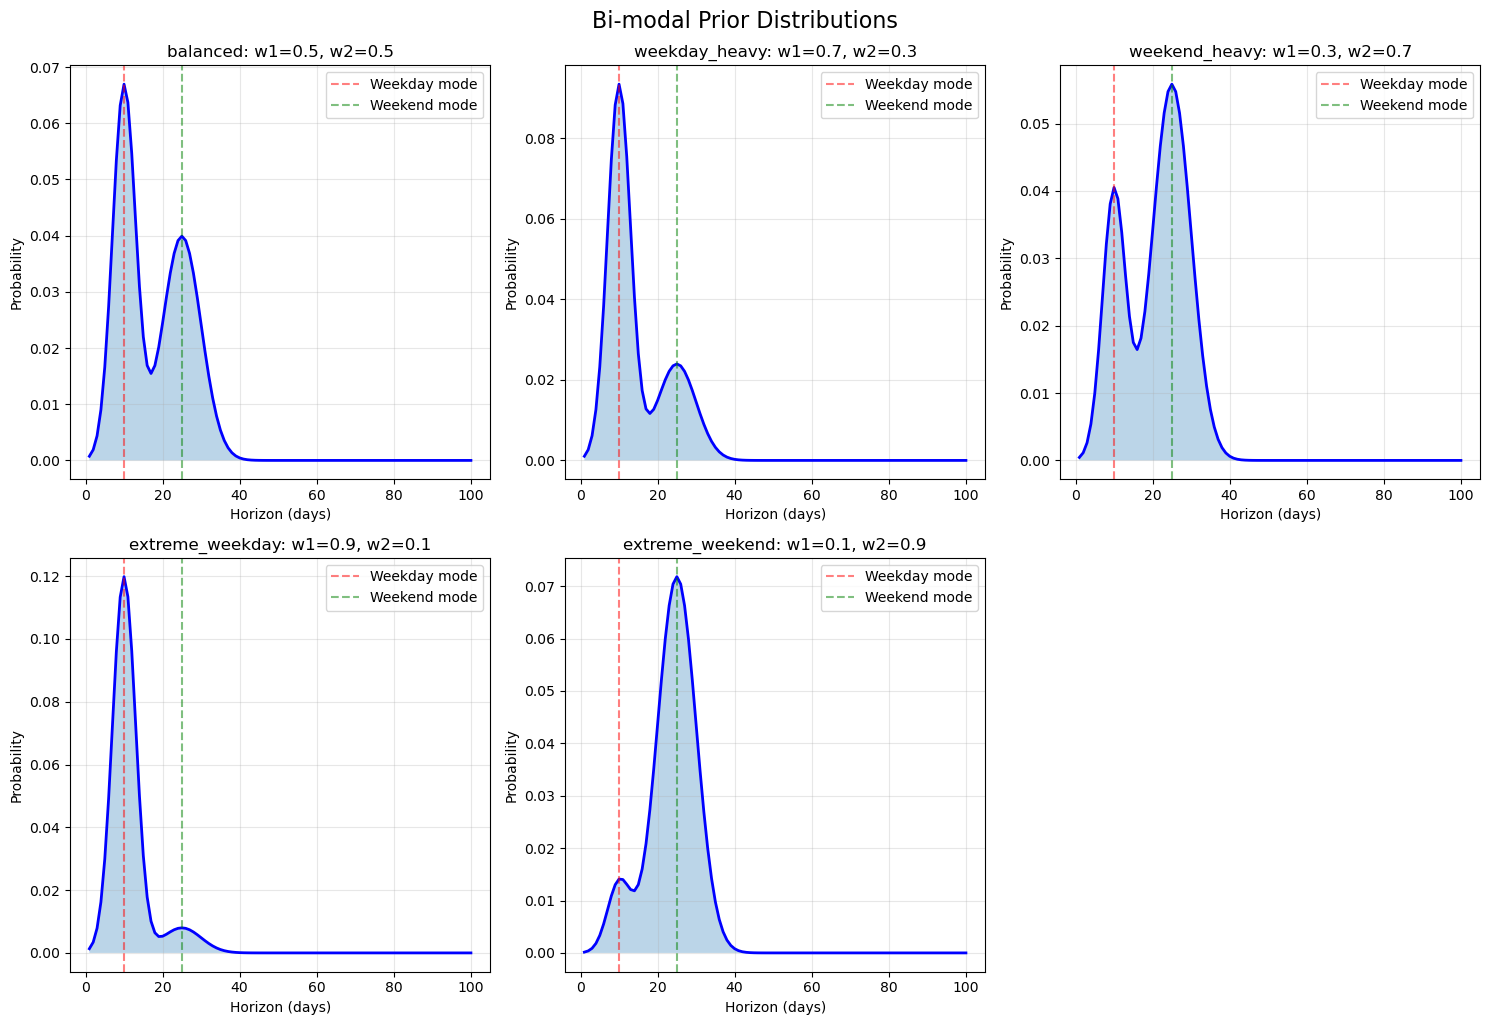


=== Tri-modal Prior Experiments (Holiday/Weekend/Weekday) ===



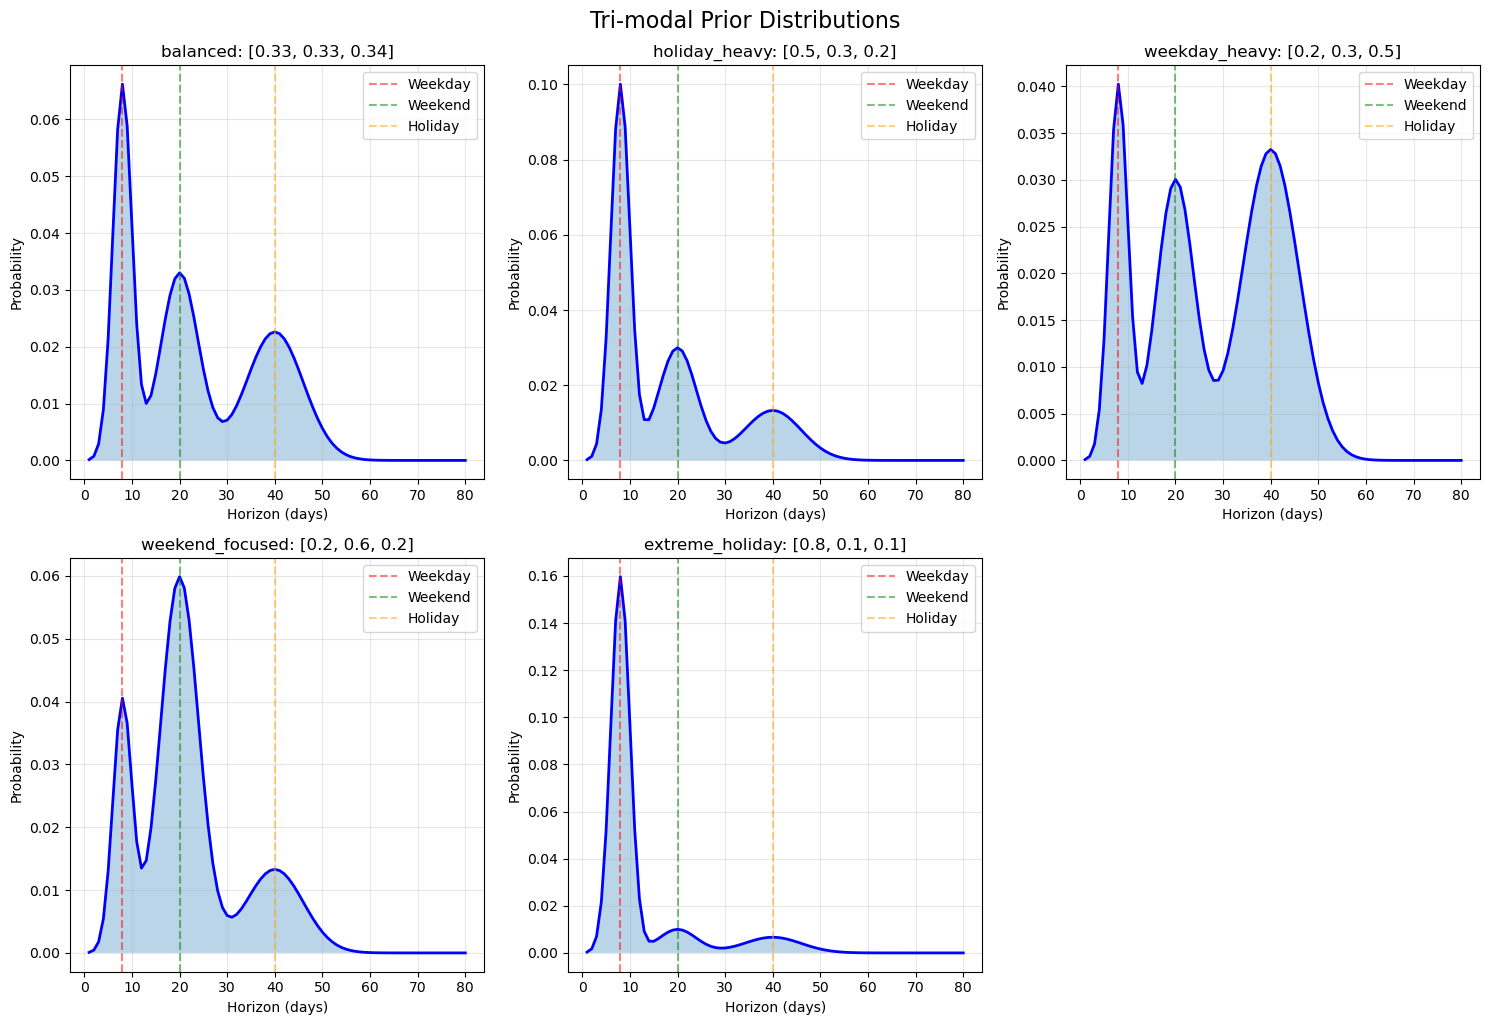


=== Seasonal Prior Experiments ===



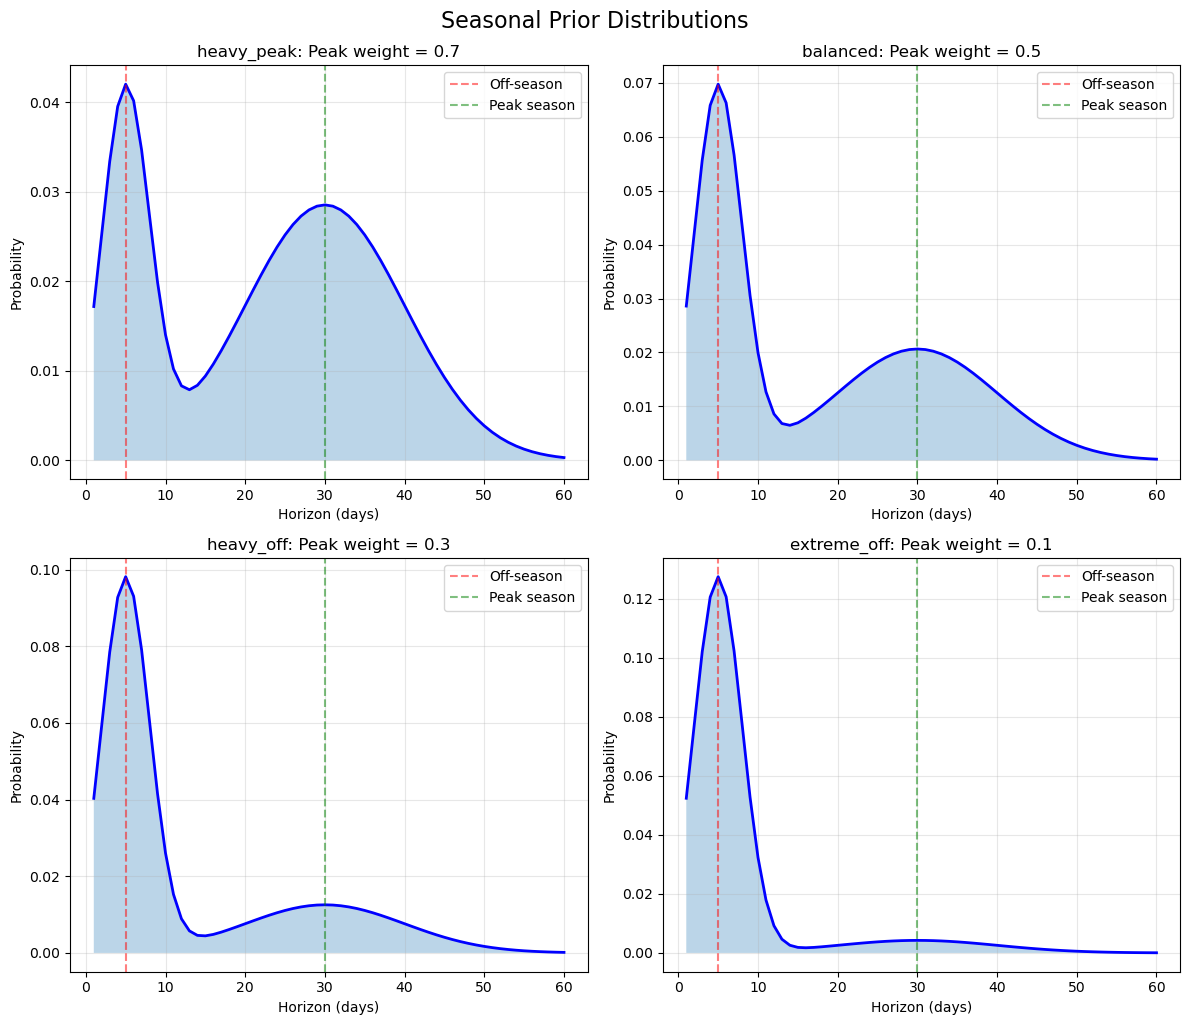


=== Performance Analysis ===



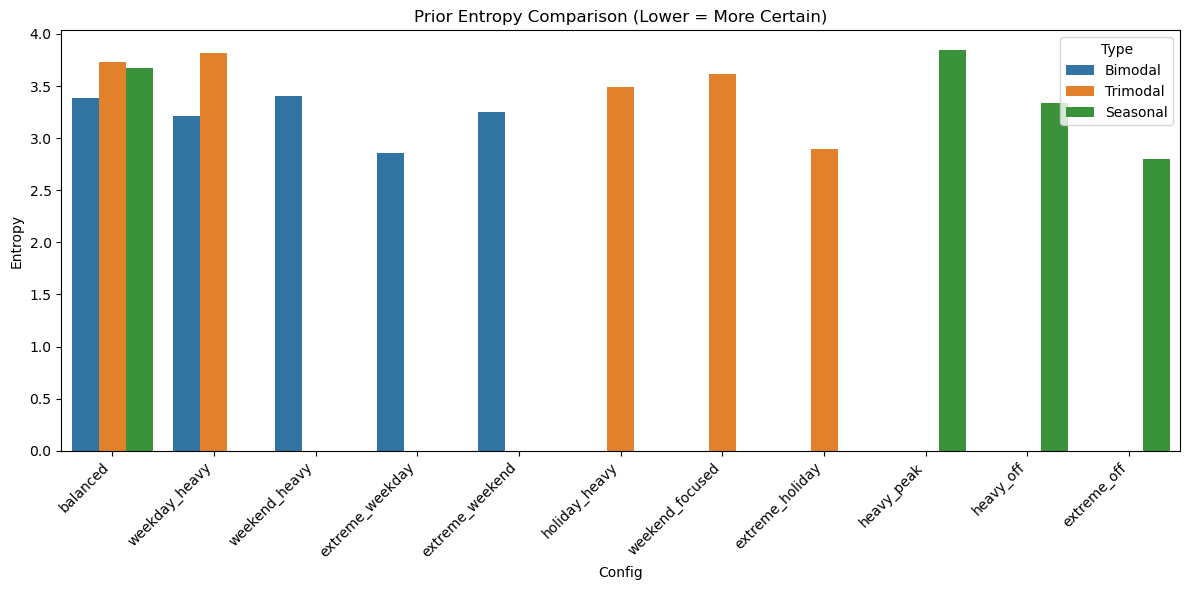


=== Recommended Weight Configurations ===

1. Bi-modal (Weekday vs Weekend):
   - Balanced: [0.5, 0.5] - when uncertainty is high
   - Typical: [0.7, 0.3] - typical weekday skier
   - Weekend warrior: [0.2, 0.8] - mostly weekends

2. Tri-modal (Weekday/Weekend/Holiday):
   - Balanced: [0.33, 0.33, 0.34] - all scenarios equal
   - Typical: [0.5, 0.3, 0.2] - weekday > weekend > holiday
   - Holiday skier: [0.1, 0.2, 0.7] - mostly holidays

3. Seasonal:
   - Peak season heavy: 0.7-0.8 - mostly during peak season
   - Balanced: 0.5 - equal peak/off-season
   - Off-season heavy: 0.2-0.3 - mostly off-season

4. Mixed Uniform-Gaussian:
   - High confidence: 0.8-0.9 Gaussian weight
   - Medium confidence: 0.5-0.7 Gaussian weight
   - Low confidence: 0.2-0.4 Gaussian weight

=== Example Integration ===

Created realistic prior with:
  Expected value: 18.3 days
  Mode: 12 days
  Entropy: 3.54


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from typing import List, Tuple, Dict
import seaborn as sns

class MultiModalPriorExperiment:
    """Multi-modal prior distributions for ski rental experiments"""
    
    def __init__(self, buy_cost: float = 100, horizon_bound: int = 500):
        self.b = buy_cost
        self.M = horizon_bound
    
    def create_bimodal_prior(self, 
                           mode1: int, mode2: int, 
                           std1: float, std2: float,
                           weight1: float) -> np.ndarray:
        """
        Create bi-modal prior (e.g., weekday vs weekend skiing)
        
        Parameters:
        - mode1, mode2: centers of the two modes
        - std1, std2: standard deviations for each mode
        - weight1: weight for first mode (weight2 = 1 - weight1)
        """
        x = np.arange(1, self.M + 1)
        
        # Create two Gaussian components
        gaussian1 = stats.norm.pdf(x, mode1, std1)
        gaussian2 = stats.norm.pdf(x, mode2, std2)
        
        # Combine with weights
        prior = weight1 * gaussian1 + (1 - weight1) * gaussian2
        
        # Normalize
        return prior / prior.sum()
    
    def create_trimodal_prior(self,
                            modes: List[int],
                            stds: List[float], 
                            weights: List[float]) -> np.ndarray:
        """
        Create tri-modal prior (e.g., holiday/weekend/weekday)
        
        Parameters:
        - modes: list of 3 mode centers
        - stds: list of 3 standard deviations
        - weights: list of 3 weights (must sum to 1)
        """
        assert len(modes) == 3 and len(stds) == 3 and len(weights) == 3
        assert abs(sum(weights) - 1.0) < 1e-6, "Weights must sum to 1"
        
        x = np.arange(1, self.M + 1)
        prior = np.zeros(self.M)
        
        for mode, std, weight in zip(modes, stds, weights):
            prior += weight * stats.norm.pdf(x, mode, std)
        
        return prior / prior.sum()
    
    def create_seasonal_prior(self,
                            peak_season_center: int = 30,
                            peak_season_std: float = 10,
                            off_season_center: int = 5, 
                            off_season_std: float = 3,
                            peak_season_weight: float = 0.3) -> np.ndarray:
        """
        Create seasonal skiing prior (peak vs off-season)
        """
        return self.create_bimodal_prior(
            off_season_center, peak_season_center,
            off_season_std, peak_season_std,
            1 - peak_season_weight
        )
    
    def create_mixed_uniform_gaussian(self,
                                    gaussian_center: int,
                                    gaussian_std: float,
                                    gaussian_weight: float) -> np.ndarray:
        """
        Mix of uniform and Gaussian (uncertainty + some knowledge)
        """
        x = np.arange(1, self.M + 1)
        
        uniform = np.ones(self.M) / self.M
        gaussian = stats.norm.pdf(x, gaussian_center, gaussian_std)
        gaussian = gaussian / gaussian.sum()
        
        prior = gaussian_weight * gaussian + (1 - gaussian_weight) * uniform
        return prior / prior.sum()

def run_multimodal_experiments():
    """Run experiments with various multi-modal priors"""
    
    # Initialize
    exp = MultiModalPriorExperiment(buy_cost=100, horizon_bound=500)
    
    # Define weight configurations to test
    weight_configs = {
        'balanced': [0.5, 0.5],
        'weekday_heavy': [0.7, 0.3],
        'weekend_heavy': [0.3, 0.7],
        'extreme_weekday': [0.9, 0.1],
        'extreme_weekend': [0.1, 0.9]
    }
    
    print("=== Bi-modal Prior Experiments (Weekday vs Weekend) ===\n")
    bimodal_results = {}

    weekday_mode, weekend_mode = 10, 25
    weekday_std, weekend_std = 3, 5
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (config_name, weights) in enumerate(weight_configs.items()):
        prior = exp.create_bimodal_prior(
            weekday_mode, weekend_mode,
            weekday_std, weekend_std,
            weights[0]
        )
        
        ax = axes[idx]
        x = np.arange(1, exp.M + 1)
        ax.plot(x[:100], prior[:100], 'b-', linewidth=2)
        ax.fill_between(x[:100], 0, prior[:100], alpha=0.3)
        ax.axvline(x=weekday_mode, color='r', linestyle='--', alpha=0.5, label='Weekday mode')
        ax.axvline(x=weekend_mode, color='g', linestyle='--', alpha=0.5, label='Weekend mode')
        ax.set_title(f'{config_name}: w1={weights[0]:.1f}, w2={weights[1]:.1f}')
        ax.set_xlabel('Horizon (days)')
        ax.set_ylabel('Probability')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        bimodal_results[config_name] = {
            'prior': prior,
            'weights': weights,
            'entropy': -np.sum(prior * np.log(prior + 1e-10))
        }
    
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.suptitle('Bi-modal Prior Distributions', y=1.02, fontsize=16)
    plt.show()
    
    print("\n=== Tri-modal Prior Experiments (Holiday/Weekend/Weekday) ===\n")
    
    trimodal_configs = {
        'balanced': [0.33, 0.33, 0.34],
        'holiday_heavy': [0.5, 0.3, 0.2],
        'weekday_heavy': [0.2, 0.3, 0.5],
        'weekend_focused': [0.2, 0.6, 0.2],
        'extreme_holiday': [0.8, 0.1, 0.1]
    }
    
    modes = [8, 20, 40]
    stds = [2, 4, 6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    trimodal_results = {}
    
    for idx, (config_name, weights) in enumerate(trimodal_configs.items()):
        prior = exp.create_trimodal_prior(modes, stds, weights)
        
        ax = axes[idx]
        x = np.arange(1, exp.M + 1)
        ax.plot(x[:80], prior[:80], 'b-', linewidth=2)
        ax.fill_between(x[:80], 0, prior[:80], alpha=0.3)
        
        colors = ['r', 'g', 'orange']
        labels = ['Weekday', 'Weekend', 'Holiday']
        for mode, color, label in zip(modes, colors, labels):
            ax.axvline(x=mode, color=color, linestyle='--', alpha=0.5, label=label)
        
        ax.set_title(f'{config_name}: {weights}')
        ax.set_xlabel('Horizon (days)')
        ax.set_ylabel('Probability')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        trimodal_results[config_name] = {
            'prior': prior,
            'weights': weights,
            'entropy': -np.sum(prior * np.log(prior + 1e-10))
        }
    
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.suptitle('Tri-modal Prior Distributions', y=1.02, fontsize=16)
    plt.show()
    
    print("\n=== Seasonal Prior Experiments ===\n")
    
    seasonal_configs = {
        'heavy_peak': 0.7,
        'balanced': 0.5,
        'heavy_off': 0.3,
        'extreme_off': 0.1
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    seasonal_results = {}
    
    for idx, (config_name, peak_weight) in enumerate(seasonal_configs.items()):
        prior = exp.create_seasonal_prior(peak_season_weight=peak_weight)
        
        ax = axes[idx]
        x = np.arange(1, exp.M + 1)
        ax.plot(x[:60], prior[:60], 'b-', linewidth=2)
        ax.fill_between(x[:60], 0, prior[:60], alpha=0.3)
        ax.axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Off-season')
        ax.axvline(x=30, color='g', linestyle='--', alpha=0.5, label='Peak season')
        ax.set_title(f'{config_name}: Peak weight = {peak_weight:.1f}')
        ax.set_xlabel('Horizon (days)')
        ax.set_ylabel('Probability')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        seasonal_results[config_name] = {
            'prior': prior,
            'peak_weight': peak_weight,
            'entropy': -np.sum(prior * np.log(prior + 1e-10))
        }
    
    plt.tight_layout()
    plt.suptitle('Seasonal Prior Distributions', y=1.02, fontsize=16)
    plt.show()
    
    print("\n=== Performance Analysis ===\n")
    
    entropy_data = []
    
    for name, results in bimodal_results.items():
        entropy_data.append({
            'Type': 'Bimodal',
            'Config': name,
            'Entropy': results['entropy']
        })
    
    for name, results in trimodal_results.items():
        entropy_data.append({
            'Type': 'Trimodal', 
            'Config': name,
            'Entropy': results['entropy']
        })
    
    for name, results in seasonal_results.items():
        entropy_data.append({
            'Type': 'Seasonal',
            'Config': name,
            'Entropy': results['entropy']
        })
    
    entropy_df = pd.DataFrame(entropy_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=entropy_df, x='Config', y='Entropy', hue='Type')
    plt.xticks(rotation=45, ha='right')
    plt.title('Prior Entropy Comparison (Lower = More Certain)')
    plt.tight_layout()
    plt.show()
    
    return bimodal_results, trimodal_results, seasonal_results

# Weight Recommendations
def print_weight_recommendations():
    """Print recommended weight configurations"""
    
    print("\n=== Recommended Weight Configurations ===\n")
    
    print("1. Bi-modal (Weekday vs Weekend):")
    print("   - Balanced: [0.5, 0.5] - when uncertainty is high")
    print("   - Typical: [0.7, 0.3] - typical weekday skier")
    print("   - Weekend warrior: [0.2, 0.8] - mostly weekends")
    
    print("\n2. Tri-modal (Weekday/Weekend/Holiday):")
    print("   - Balanced: [0.33, 0.33, 0.34] - all scenarios equal")
    print("   - Typical: [0.5, 0.3, 0.2] - weekday > weekend > holiday")
    print("   - Holiday skier: [0.1, 0.2, 0.7] - mostly holidays")
    
    print("\n3. Seasonal:")
    print("   - Peak season heavy: 0.7-0.8 - mostly during peak season")
    print("   - Balanced: 0.5 - equal peak/off-season")
    print("   - Off-season heavy: 0.2-0.3 - mostly off-season")
    
    print("\n4. Mixed Uniform-Gaussian:")
    print("   - High confidence: 0.8-0.9 Gaussian weight")
    print("   - Medium confidence: 0.5-0.7 Gaussian weight")
    print("   - Low confidence: 0.2-0.4 Gaussian weight")

if __name__ == "__main__":
    bimodal, trimodal, seasonal = run_multimodal_experiments()
    print_weight_recommendations()
    
    print("\n=== Example Integration ===")
    
    exp = MultiModalPriorExperiment()
    
    realistic_prior = exp.create_bimodal_prior(
        mode1=12,
        mode2=30,
        std1=4,
        std2=8,
        weight1=0.65
    )
    
    print(f"\nCreated realistic prior with:")
    print(f"  Expected value: {np.sum(np.arange(1, exp.M+1) * realistic_prior):.1f} days")
    print(f"  Mode: {np.argmax(realistic_prior) + 1} days")
    print(f"  Entropy: {-np.sum(realistic_prior * np.log(realistic_prior + 1e-10)):.2f}")
